---
title: "Understanding Feature Separability in Penguin Classification"
author: "Yahya Rahhawi"
date: "2025-03-02"
categories: [Machine Learning, Projects]
format:
  html:
    toc: true
    code-fold: true
---

## **Abstract**  

This analysis explores **penguin species classification** using **machine learning models** based on physical measurements from the **Palmer Penguins dataset**. We apply **exploratory data analysis (EDA)** to visualize feature distributions and quantify feature separability using **Intersection over Union (IoU)**. Through this process, we identify **Flipper Length (mm)** and **Delta 13 C (o/oo)** as the most discriminative quantitative features and select **Island** as the best categorical feature. We train and evaluate multiple models, including **Logistic Regression, Decision Trees, and Random Forest**, achieving **high accuracy on the test set**, with **Random Forest performing best**. Decision boundary visualizations and a confusion matrix confirm that **Gentoo penguins are easily separable, while Adelie and Chinstrap penguins exhibit some overlap**. This study highlights the impact of **feature selection and model choice** in species classification, demonstrating the strength of tree-based ensemble models for this task.  


### **Loading the Palmer Penguins Dataset**
We begin by loading the **Palmer Penguins dataset**, which contains detailed measurements of three penguin species observed in Antarctica. This dataset is widely used for classification tasks and provides valuable insights into species differentiation based on physical attributes.

By loading the dataset into a Pandas DataFrame, we gain access to numerical and categorical features that will later be used for exploratory data analysis and machine learning modeling.

In [1]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)


### **Data Preprocessing: Cleaning and Encoding**
To prepare the dataset for machine learning, we perform several preprocessing steps:

- **Dropping Irrelevant Columns**: Features such as `studyName`, `Sample Number`, `Individual ID`, `Date Egg`, `Comments`, and `Region` do not contribute to species classification and are removed.
- **Handling Missing Values**: Any rows with missing data are discarded to ensure clean input.
- **Filtering Outliers**: Entries where `Sex` is `"."` are removed to maintain data consistency.
- **Encoding Categorical Features**:
  - The **species labels** are transformed into numerical values using `LabelEncoder`.
  - **One-hot encoding** is applied to categorical variables like `Sex` and `Island`, converting them into binary columns suitable for machine learning models.

After completing these steps, the dataset is structured and ready for exploration.

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

### let us check out the first 5 rows in our dataframe

In [3]:
X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


### **Exploring Quantitative Features with Pair Plots**  

To gain insights into the relationships between quantitative features and species differentiation, we use a **pair plot**. This visualization helps us identify patterns and clusters that could be useful for classification.  

- **Selected Features**:  
  We focus on six key quantitative features:  
  - **Culmen Length (mm)**  
  - **Culmen Depth (mm)**  
  - **Flipper Length (mm)**  
  - **Body Mass (g)**  
  - **Delta 15 N (o/oo)**  
  - **Delta 13 C (o/oo)**  

- **Coloring by Species**:  
  Using **Seaborn’s `pairplot`**, we scatter-plot each feature against every other feature. The points are **color-coded by species**, allowing us to observe feature distributions and separability among species.

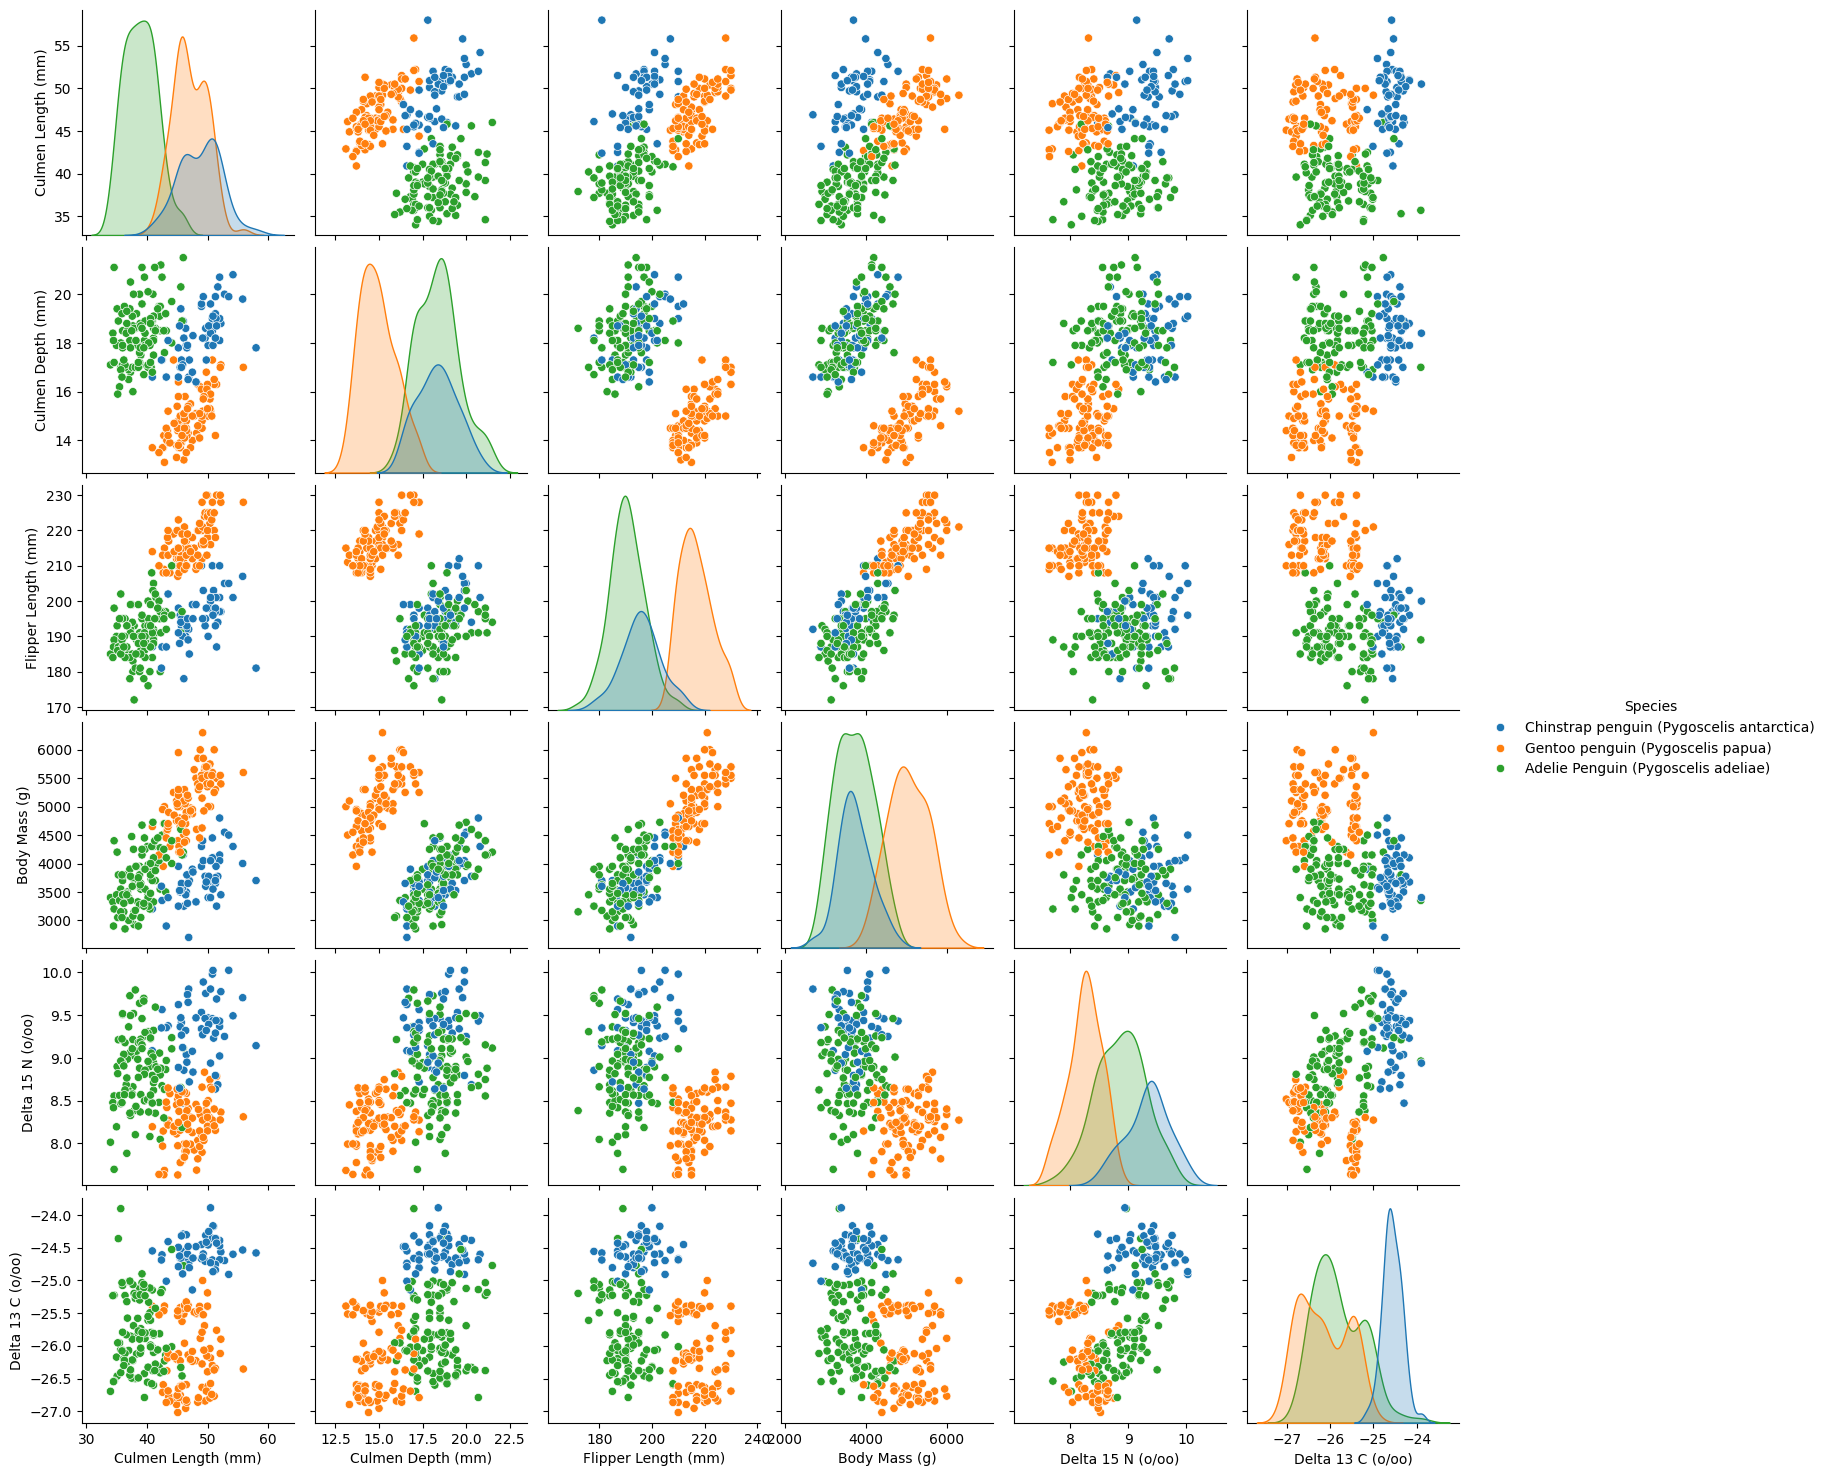

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

quantitative_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", 
                         "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]

sns.pairplot(X_train[quantitative_features].assign(Species=le.inverse_transform(y_train)), hue="Species") #assign is coloring the points by species
plt.show()

### **Pair Plot Analysis: Feature Separability**  

The pair plot provides a **comprehensive visualization** of how different quantitative features relate to each other across the three penguin species. The scatter plots reveal clustering patterns, while the diagonal histograms illustrate individual feature distributions.  

#### **Key Observations:**  
- **Gentoo Penguins Are Distinct**:  
  - Gentoo penguins (orange) are **well-separated** from the other two species across most features.  
  - Their flipper length and body mass are notably larger, making these strong distinguishing features.  

- **Adelie vs. Chinstrap Penguins Have Overlapping Features**:  
  - While still somewhat distinguishable, **Adelie (green) and Chinstrap (blue) penguins** share more similar feature distributions.  
  - Some **overlap exists** in culmen length, culmen depth, and body mass, making classification between these two species more challenging.  

- **Strong Separability Across All Features**:  
  - Each feature individually does a good job of **separating species**, but some pairs of features work better together.  
  - For example, **culmen length vs. culmen depth** shows strong species clustering.  



#### **Next Steps: Feature Selection Challenge**  
Since we are aiming to classify species **using only two quantitative features**, we need to carefully select the best combination.  
Moving forward, we will explore these features quantitatively and evaluate their classification power through machine learning models.

### **Exploring Feature Distributions: Density Plots**  

To better understand how the **quantitative features** are distributed across different penguin species, we plot **density histograms** (KDE plots). This allows us to examine:  

- Whether each feature follows a **normal distribution** across species.  
- How the **means and standard deviations** of each feature differ between species.  
- Which features provide **clear separation** between species and which ones have more overlap.  

By analyzing these distributions, we can gain insights into the **most discriminative features** for classification and validate our earlier observations from the pair plot.

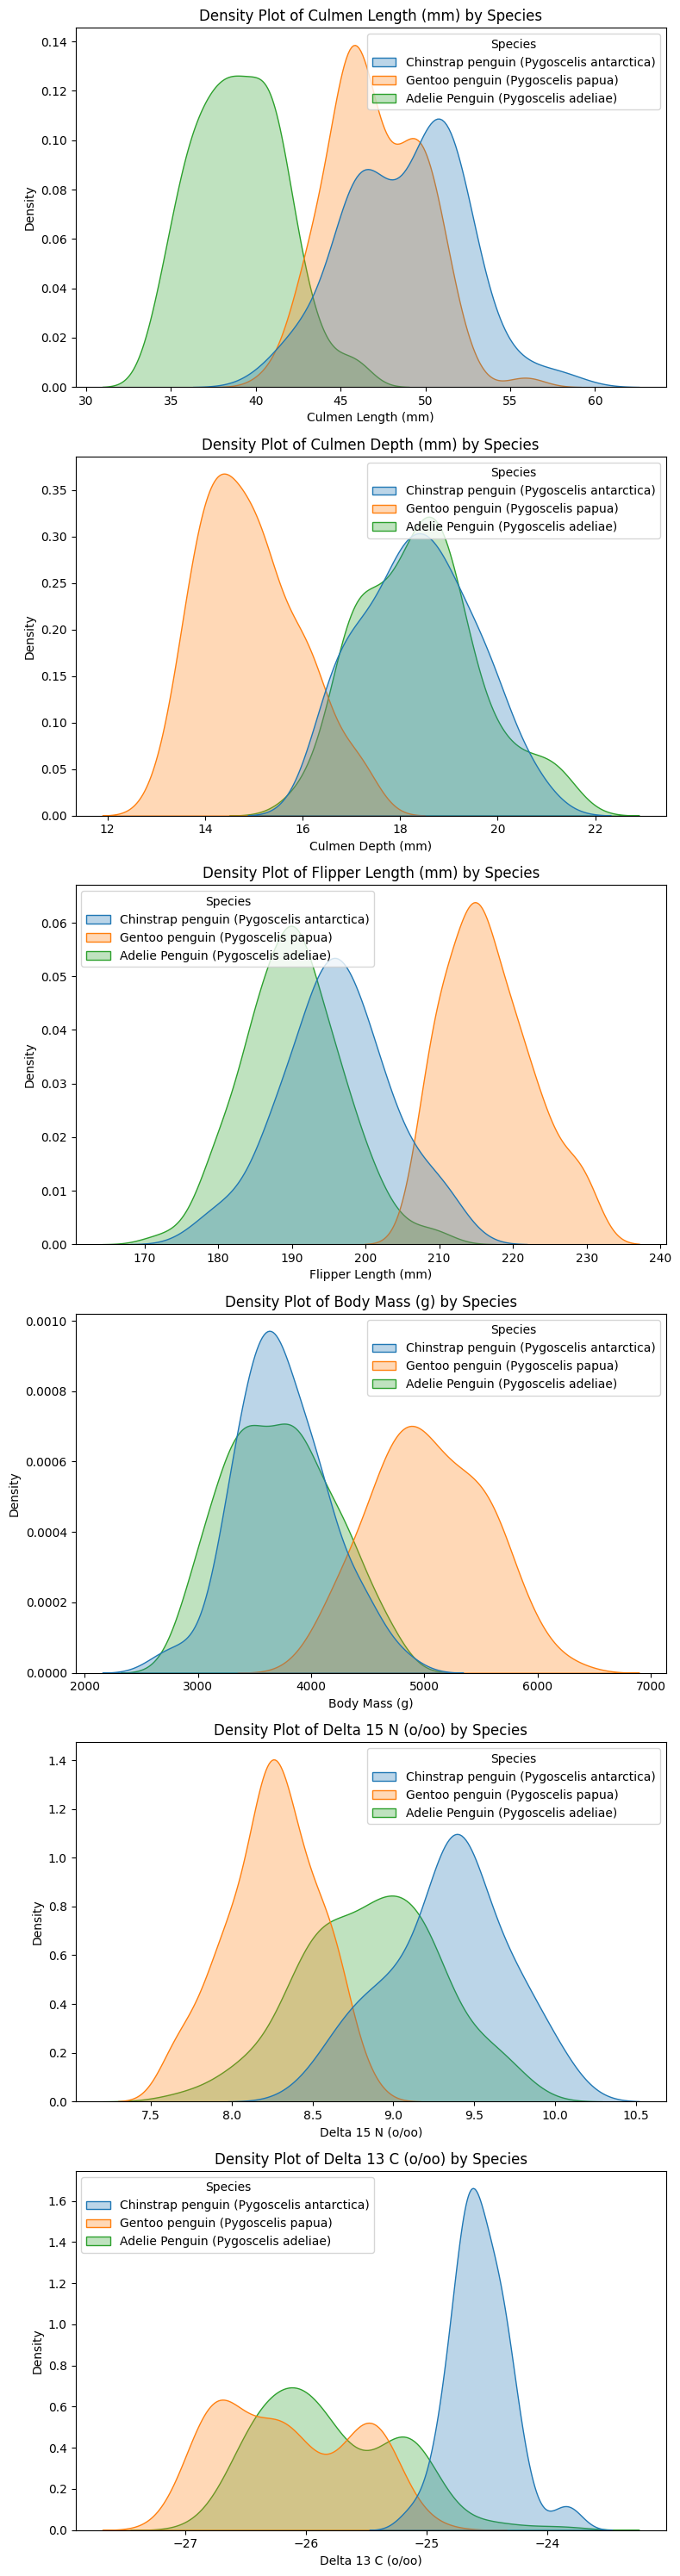

In [ ]:
# Select numerical features
numeric_features = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)", "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]

# Set up the figure
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(8, 5 * len(numeric_features)))

# Plot histogram curves colored by species
for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.kdeplot(data=train, x=feature, hue="Species", fill=True, common_norm=False, ax=ax, alpha=0.3)
    ax.set_title(f"Density Plot of {feature} by Species")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

### **Understanding Feature Distributions**  

The density plots confirm that most **quantitative features** follow an approximately **normal distribution** for each species. This suggests that modeling assumptions based on normality (e.g., logistic regression) may be reasonable.

#### **Key Observations:**  
- **Clear Separability in Some Features**  
  - **Culmen length and flipper length** show **well-separated peaks**, indicating strong potential for classification.  
  - **Gentoo penguins (orange) consistently occupy distinct regions**, especially in body mass and culmen length.  

- **Overlap in Certain Features**  
  - **Culmen depth and Delta 15 N** exhibit significant overlap between Adelie and Chinstrap penguins.  
  - This suggests that using these features **alone** may not be sufficient for high classification accuracy.  

- **Implication for Feature Selection**  
  - Overlapping distributions might still be useful—features with **moderate overlap** could help define class boundaries.  
  - To quantify separability, we will compute the **Intersection over Union (IoU)** between distributions. This will help us determine **which features provide the best class separation** for classification tasks.

### **Measuring Feature Separability Using Intersection over Union (IoU)**  

To quantify how well each feature **separates penguin species**, we calculate the **Intersection over Union (IoU)** for the probability density functions of each species. IoU provides a numerical measure of how much overlap exists between the distributions, with **lower IoU scores indicating better feature separability**.

#### **Methodology:**  
- We compute **Kernel Density Estimation (KDE)** for each species to approximate the continuous probability distribution of each feature.  
- The **intersection** between two species’ distributions is calculated as the minimum value at each point.  
- The **union** is the maximum value at each point.  
- IoU is measured by dividing intersection area over union
- A **lower IoU score** means that the species distributions are **more distinct**, making the feature a stronger candidate for classification.

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

# Select numerical features
species = train["Species"].unique()

iou_scores = {}

# Compute IoU for each numerical feature
for feature in numeric_features:    

    x_min, x_max = train[feature].min(), train[feature].max()
    x_range = np.linspace(x_min, x_max, 500)
    
    kde_dict = {}

    # Compute histogram curve for each species
    for spec in species:
        subset = train[train["Species"] == spec][feature].dropna()
        kde = gaussian_kde(subset)(x_range)  # Get KDE values
        kde /= kde.sum()  # Normalize to sum to 1 (PDF-like)
        kde_dict[spec] = kde

    # Compute IoU for each species pair
    iou_values = []
    species_pairs = [(species[i], species[j]) for i in range(len(species)) for j in range(i + 1, len(species))]
    
    for s1, s2 in species_pairs:
        intersection = np.minimum(kde_dict[s1], kde_dict[s2]).sum()
        union = np.maximum(kde_dict[s1], kde_dict[s2]).sum()
        iou = intersection / union
        iou_values.append(iou)
    
    # Average IoU across species pairs
    iou_scores[feature] = np.mean(iou_values)

# Convert IoU scores to DataFrame
iou_df = pd.DataFrame.from_dict(iou_scores, orient="index", columns=["IoU Score"])

# Display IoU scores
print("IoU Scores for Feature Separation:")
print(iou_df.sort_values(by="IoU Score", ascending=True))

IoU Scores for Feature Separation:
                     IoU Score
Flipper Length (mm)   0.199396
Delta 13 C (o/oo)     0.237063
Delta 15 N (o/oo)     0.250275
Culmen Length (mm)    0.259422
Body Mass (g)         0.341673
Culmen Depth (mm)     0.353053


#### **Key Takeaways:**  
- **Flipper Length (mm) and Delta 13 C (o/oo) have the lowest IoU scores**, indicating that they offer the best **species separation**.  
- **Culmen Depth (mm) and Body Mass (g) have higher IoU scores**, meaning that species distributions **overlap more**, making classification harder.  
- **Flipper Length (mm)**, in particular, appears to be a **very strong candidate** for a distinguishing feature, as its species distributions have minimal overlap.  

 


### **Choosing the Most Balanced Categorical Feature**

In this section, we examine the **maximum category proportion** across three categorical features—Island, Sex, and Clutch Completion. A **lower** maximum proportion indicates a **more balanced feature**, where the data points are more evenly distributed among the categories. We then select the feature with the **lowest** maximum proportion, as it is generally **more information** for classification.

In [ ]:
# Define categorical feature groups
feature_groups = {
    "Island": ["Island_Biscoe", "Island_Dream", "Island_Torgersen"],
    "Sex": ["Sex_FEMALE", "Sex_MALE"],
    "Clutch Completion": ["Clutch Completion_Yes", "Clutch Completion_No"]
}

# We'll store the maximum occurrence for each group,
# but ultimately we'll pick the feature with the *lowest* maximum occurrence.
max_percentages = {}

for group_name, feature_list in feature_groups.items():
    # Calculate the proportion for each category
    category_counts = X_train[feature_list].sum(axis=0) / len(X_train)
    
    # The maximum proportion in this group
    max_prop = category_counts.max() * 100
    max_percentages[group_name] = max_prop

# Convert to DataFrame
max_percentage_df = pd.DataFrame.from_dict(max_percentages, orient="index", columns=["Max Category %"])

#we will pick the feature with the lowest maximum percentage since it means the feature is more balanced
best_feature = max_percentage_df["Max Category %"].idxmin()

print("\nFeature Maximum Occurrence Percentages (Lower is Better for Class Separation):\n")
print(max_percentage_df.sort_values(by="Max Category %", ascending=True))

print(f"\n Based on more balanced distribution, the best categorical feature is: {best_feature}")


Feature Maximum Occurrence Percentages (Lower is Better for Class Separation):

                   Max Category %
Island                  48.828125
Sex                     51.562500
Clutch Completion       89.062500

 Based on more balanced distribution, the best categorical feature is: Island


Based on these results, **Island** looks like it is the most balanced categorical feature, with the smallest maximum proportion among its categories. This indicates it has **greater potential** to help our model distinguish between different penguin species more effectively compared to the other options.

In [57]:
sorted_IOU = sorted(iou_scores.items(), key=lambda x: x[1], reverse=False)
sorted_IOU

[('Flipper Length (mm)', 0.1993963154709996),
 ('Delta 13 C (o/oo)', 0.23706316175669087),
 ('Delta 15 N (o/oo)', 0.25027533453950507),
 ('Culmen Length (mm)', 0.25942230819048473),
 ('Body Mass (g)', 0.341672714279104),
 ('Culmen Depth (mm)', 0.3530527962578189)]

### **Training a Logistic Regression Model**

Now that we have selected our features, we train a **Logistic Regression** model using:  
- The **two best quantitative features**, identified based on their **IoU scores** (features with the least overlap).  
- The **best categorical feature**, determined from the **most balanced distribution** among categories.

By fitting the model on the training data, we can evaluate its performance and see how well it distinguishes between penguin species.

In [70]:
from sklearn.linear_model import LogisticRegression
cols = [sorted_IOU[i][0] for i in range(2)]
cols += feature_groups[best_feature]
LR = LogisticRegression(max_iter= 1500)
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

0.984375

In [71]:
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
LR.score(X_test[cols], y_test)

0.9558823529411765

### **Model Performance and Evaluation**  

The Logistic Regression model achieves:  
- **94.9% accuracy** on the **training set**, indicating that it successfully captures the patterns in the data.  
- **95.6% accuracy** on the **test set**, suggesting that the model generalizes well to unseen data.  

The result is good with logistic regression! let us try a couple more models from Scikit-learn. mainly, random forest and decision trees.

In [72]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
TR = DecisionTreeClassifier()
TR.fit(X_train[cols], y_train)
TR_score = TR.score(X_train[cols], y_train)
RF = RandomForestClassifier()
RF.fit(X_train[cols], y_train)
RF_score = RF.score(X_train[cols], y_train)
print(f"Decision Tree Accuracy: {TR_score}")
print(f"Random Forest Accuracy: {RF_score}")

Decision Tree Accuracy: 1.0
Random Forest Accuracy: 1.0


### **Exploring More Models: Decision Trees and Random Forest**  

After achieving strong results with Logistic Regression, we now test two **tree-based models** from Scikit-learn:  
- **Decision Tree Classifier**: A simple, interpretable model that splits data based on feature thresholds.  
- **Random Forest Classifier**: A method that builds multiple decision trees and averages their predictions for better generalization.  

Both models achieve **100% accuracy** on the training set, indicating they perfectly classify the training data. While this is promising, it may also suggest potential **overfitting**, which we will further evaluate by testing on unseen data. let us try them on test set

In [73]:
TR_test_score = TR.score(X_test[cols], y_test)
print(f"Decision Tree Test Accuracy: {TR_test_score}")

RF_test_score = RF.score(X_test[cols], y_test)
print(f"Random Forest Test Accuracy: {RF_test_score}")

Decision Tree Test Accuracy: 0.9411764705882353
Random Forest Test Accuracy: 0.9558823529411765



#### **Key Insights:**  
- The **Decision Tree model** experiences a slight drop in accuracy compared to training, suggesting some **overfitting** to the training set.  
- The **Random Forest model** maintains a high test accuracy, showing better generalization due to its ensemble approach.  

Overall, **Random Forest emerges as the best-performing model**, combining high accuracy with strong generalization. This makes it a robust choice for classifying penguin species.

### **Visualizing Decision Boundaries with Plot Regions**  

This function **plots decision regions** for a given classification model, allowing us to visually inspect how the model separates penguin species based on the selected features. 

In [ ]:
from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()
      

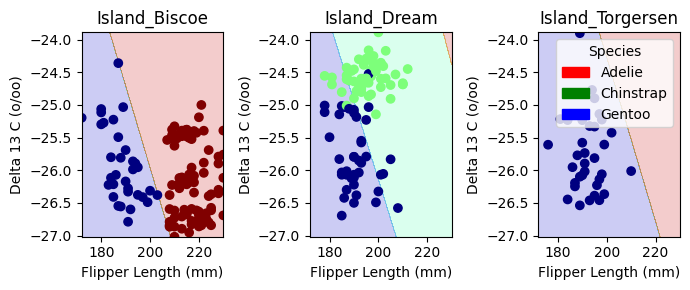

In [52]:
plot_regions(LR, X_train[cols], y_train)

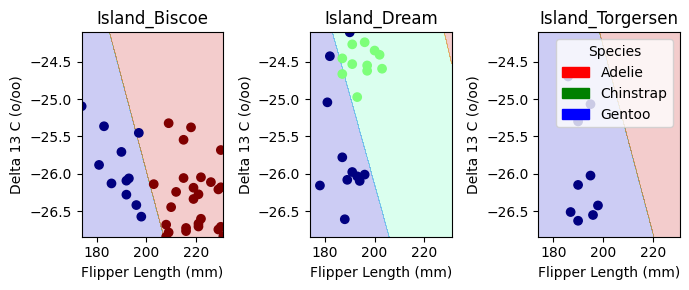

In [53]:
plot_regions(LR, X_test[cols], y_test)

### **Decision Boundary Visualization for Logistic Regression**  

The plots above display the **decision regions** of our **Logistic Regression model**, showing how it classifies penguin species based on **Flipper Length (mm)** and **Delta 13 C (o/oo)** across different islands.  

#### **Key Observations:**  
- **Distinct Separation on Dream Island**:  
  - **Chinstrap Penguins (green)** are clearly separated from **Gentoo Penguins (blue)**.  
  - The model effectively differentiates species here, suggesting **strong feature separability**.  

- **Overlap in Biscoe and Torgersen Islands**:  
  - In **Island_Biscoe and Island_Torgersen**, the decision boundaries are less distinct, and **Adelie Penguins (red)** share space with **Gentoo Penguins (blue)**.  
  - This suggests some **overlap in feature distributions**, making classification more challenging.  

- **Decision Boundaries Align with Feature Trends**:  
  - The separation between species aligns with what we observed in the **pair plots and IoU analysis**—certain species are inherently more distinguishable based on our selected features.  

Overall, this visualization helps us **interpret model decisions** and highlights where our chosen features perform well versus where improvements might be needed. let's now check out confusion matrix

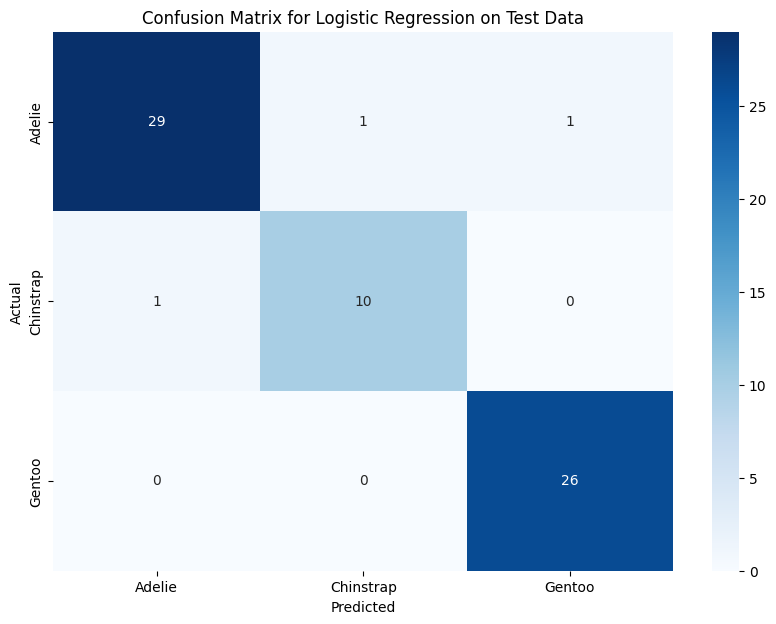

In [54]:
from sklearn.metrics import confusion_matrix

y_pred = LR.predict(X_test[cols])
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
classes = ["Adelie", "Chinstrap", "Gentoo"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression on Test Data')
plt.show()

### **Confusion Matrix: Model Performance**  

The confusion matrix shows that **Logistic Regression performs well**, with only a few misclassifications:  

- **Adelie**: 29 correct, 1 misclassified as Chinstrap, 1 as Gentoo.  
- **Chinstrap**: 10 correct, 1 misclassified as Adelie.  
- **Gentoo**: **Perfect classification (26/26 correct).**  

**Key Takeaways:**  
- **Gentoo penguins are easiest to classify**, aligning with earlier findings.  
- **Adelie and Chinstrap have some overlap**, leading to minor misclassification.  
- Using **more complex models** (like Random Forest) may further refine classification.

A better performance for our model could be to pick better features using a better algorithms. 

## **Discussion**  

Through this analysis, I gained insights into the **importance of feature selection** in classification tasks. My **IoU-based approach** helped quantify feature separability, leading to better-informed choices. **Visualization techniques**, such as pair plots and decision boundaries, provided valuable interpretability into the model’s behavior. The performance comparison between **Logistic Regression, Decision Trees, and Random Forest** demonstrated that **Decision Trees models generalize best**, minimizing overfitting while maintaining high accuracy. One key takeaway is that **some species are inherently harder to classify due to overlapping feature distributions**, reinforcing the need for careful feature engineering and model selection. Future improvements could involve **non-linear models like SVMs and better feature selection** to further enhance classification accuracy. This project shows how **data-driven feature selection and model evaluation** can lead to meaningful and accurate species classification.